## __Plato Notebook 3: Slab pull optimisation__

Thomas Schouten, Whitney Behr, Edward Clennett, Thorsten Becker


#### __0. Prepare Python__

First, we load the required packages.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from plato.optimisation import Optimisation
from plato.plate_torques import PlateTorques
from plato.plot import PlotReconstruction

#### __1. Set up the PlateTorques object__

The below cell loads a `PlateTorques` object for the Müller et al. (2016) reconstruction by providing the ages of interest and the model string identifier "Muller2016", which automatically downloads the relevant files from the GPlately DataServer.

To accelerate the initialisation, the seafloor age and continental grids are loaded from the sample data folder. The seafloor age grids were obtained from the GPlately DataServer; the continental grids were obtained by reconstructing the present-day elevation as well as the depths of the Moho and lithosphere-asthenosphere (LAB) boundary from Lithoref (Afonso et al., 2019) using the `reconstruct` method of the GPlately `Raster` object.

In [2]:
# Set parameters
TEST_RUN = False        # Whether or not to run a small sample of ages
COMPUTE_TORQUES = False  # Whether or not to compute torques
OPTIMISE_TORQUES = False # Whether or not to optimise torques
PLOT_FIGS = True        # Whether or not to plot the results

# Plate reconstruction
reconstruction_name = "Muller2016" 

# Reconstruction ages of interest
if TEST_RUN:
    ages = [0, 45]
else:
    ages = np.arange(0, 91, 1)

# Define the model combinations
if TEST_RUN:
    M2016_models = ["Lr-Hb", "Lr-Gd"]
else:
    M2016_models = ["Lr-Hb", "Lr-Gd", "Lr-Sl", "Hr-Hb", "Lr-Hb_alt"]

# Plates of interest
plateIDs = [501, 608, 901, 902, 903, 904, 909, 911, 918, 926]
plate_names = ["India", "Philippine Sea", "Pacific", "Farallon", "Juan de Fuca", "Aluk", "Cocos", "Nazca", "Kula", "Izanagi"]

# Load excel file with settings
settings_file = os.path.join(os.getcwd(), "settings.xlsx")

# Set directory with sample data
data_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "sample_data", "M2016"))

# Set directory to save the results
results_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "output_notebooks", "03-Uncertainty_analysis"))

# Set directory to save the figures
figs_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "figures_notebooks", "03-Uncertainty_analysis"))

# Load seafloor age and continental grids
seafloor_age_grids = {}; continental_grids = {}
for age in ages:
    seafloor_age_grids[age] = xr.open_dataset(os.path.join(data_dir, "seafloor_age_grids", f"M2016_SeafloorAgeGrid_{age}Ma.nc"))

In [3]:
# Set up PlateTorques objects
M2016 = {}
for model in M2016_models:
    M2016[model] = PlateTorques(
        reconstruction_name = "Muller2016",
        ages = ages,
        cases_file = settings_file,
        cases_sheet = "3a - Uncertainty analysis" if model == "Lr-Hb" else "3b - Uncertainty analysis",
        files_dir = os.path.join(results_dir, model),
        rotation_file = os.path.join(data_dir, "gplates_files", "M2016_alt_rotations_Lr-Hb.rot" if model == "Lr-Hb_alt" else f"M2016_rotations_{model}.rot"),
        topology_file = os.path.join(data_dir, "gplates_files", "M2016_alt_topologies.gpml" if model == "Lr-Hb_alt" else "M2016_topologies.gpml"),
        polygon_file = os.path.join(data_dir, "gplates_files",  "M2016_static_polygons.gpml"),
        seafloor_age_grids = seafloor_age_grids,
    )

Calculating RMS velocities: 100%|██████████| 91/91 [00:00<00:00, 50614.20it/s]


#### __2. Sampling seafloor ages__

The below cell calls the `sample_slab_seafloor_ages` method of the `PlateTorques` object to sample seafloor ages at subduction zones and grid points.

In [4]:
# If test run, do no include Pacific and India
if COMPUTE_TORQUES:
    for key, model in M2016.items():
        if "Lr-Hb" in key:
            model.sample_slab_seafloor_ages(cases = ["ref", "nnr"] if key == "Lr-Hb" else ["ref"])

#### __3. Removing net rotation__

The below cell removes the net lithospheric rotation component of plate motion using the `remove_net_rotation` method of the `PlateTorques` object.

In [5]:
# Remove net rotation for all NNR cases
M2016["Lr-Hb"].remove_net_rotation(cases = "nnr")

Calculating RMS velocities: 100%|██████████| 91/91 [00:02<00:00, 33.28it/s]


#### __4. Torque calculation__

The below cell uses the `calculate_all_torques` method of the `PlateTorques` object to compute the full torque balance for all cases with reconstructed motions.

In [6]:
if COMPUTE_TORQUES:
    # Compute the torques for the other models
    for key, model in M2016.items():
        print(f"Computing torques for model {key}...")
        # Skip the Lr-Hb model as it has already been computed.
        if key == "Lr-Hb":
            model.calculate_all_torques(cases = ["ref", "nnr"])

        elif key == "Lr-Hb_alt":
            model.calculate_all_torques(cases = "ref")
        
        else:
            # Compute mantle drag torque
            model.calculate_mantle_drag_torque()

            # Rotate slab pull and GPE torques from Lr-Hb to the current model
            for torque in ["slab_pull_torque", "GPE_torque"]:
                model.rotate_torque(
                    reference_rotations = M2016["Lr-Hb"].reconstruction.rotation_model,
                    reference_plates = M2016["Lr-Hb"].plates,
                    torque = torque,
                )

#### __5. Optimisation__

The below cells initialise an `Optimisation` object, that contains methods to optimise the free parameters in the plate torque balance, using the `PlateTorques` object.

Then

In [7]:
# Initialise Optimisation objects
optimise_M2016 = {}
for key, model in M2016.items():
    optimise_M2016[key] = Optimisation(model)

In [8]:
# Simple optimisation
if OPTIMISE_TORQUES:
    for key, model in optimise_M2016.items():
        for case in model.cases:
            if "syn" in case:
                continue

            print(f"Optimising torques for model {key} and case {case}...")

            # Find optimal parameters for each model
            _, optimal_parameters, _ = model.minimise_residual_torque(ages = 0, cases = case, plateIDs = [901, 909, 911])

            # Apply the parameters
            model.apply_parameters(optimal_parameters[0], cases = case)

#### __6. Synthetic velocities__

The below cells 

In [9]:
# Copy slab pull constants to synthetic cases
if OPTIMISE_TORQUES:
    for key, model in M2016.items():
        for age in model.ages:
            for case in model.cases:
                if "syn" or "nnr" in case:
                    continue
                
                for component in ["x", "y", "z", "mag"]:
                    model.plates.data[age][f"syn_{case}"][f"slab_pull_torque_{component}"] = model.plates.data[age][f"syn_{case}"][f"slab_pull_torque_{component}"].copy()
                    model.plates.data[age][f"syn_{case}"][f"GPE_torque_{component}"] = model.plates.data[age][f"syn_{case}"][f"GPE_torque_{component}"].copy()
                    model.plates.data[age][f"syn_{case}"][f"mantle_drag_torque_{component}"] = model.plates.data[age][f"syn_{case}"][f"mantle_drag_torque_{component}"].copy()

                model.calculate_synthetic_velocity(ages = age, cases = f"syn_{case}", PROGRESS_BAR = False)

In [10]:
# Save all data if the torques have been computed
if COMPUTE_TORQUES or OPTIMISE_TORQUES and not TEST_RUN:
    for key, model in M2016.items():
        model.save_all()

#### __7. Visualisation__

The below cells 

In [11]:
# Plotting parameters
cm2in = 0.3937008
fig_width = 18*cm2in*2; fig_height_graphs = 8*cm2in*2; fig_height_maps = 10*cm2in*2
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Arial"
title_fontsize = 20
plot_times = [45, 60, 75, 90]
projection = ccrs.Robinson(central_longitude = 160) 
annotations = ["a", "b", "c", "d"]

model_colours = plt.get_cmap("cmc.batlow")(np.linspace(0, 1, len(M2016_models)+1))

In [12]:
# Extract reconstructed RMS velocity components
rms_speed = {}; rms_spin_rate = {}
for key, model in M2016.items():
    rms_speed[key] = model.extract_data_through_time(plateIDs = plateIDs, var = "velocity_rms_mag")
    rms_spin_rate[key] = model.extract_data_through_time(plateIDs = plateIDs, var = "spin_rate_rms_mag")

# Extract optimised torques for each case
driving_torque = {}; residual_torque = {}
for key, model in M2016.items():
    driving_torque[key] = model.extract_data_through_time(cases = ["ref", "nnr"] if key == "Lr-Hb" else "ref", plateIDs = plateIDs, var = "driving_torque_mag")
    residual_torque[key] = model.extract_data_through_time(cases = ["ref", "nnr"] if key == "Lr-Hb" else "ref", plateIDs = plateIDs, var = "residual_torque_mag")

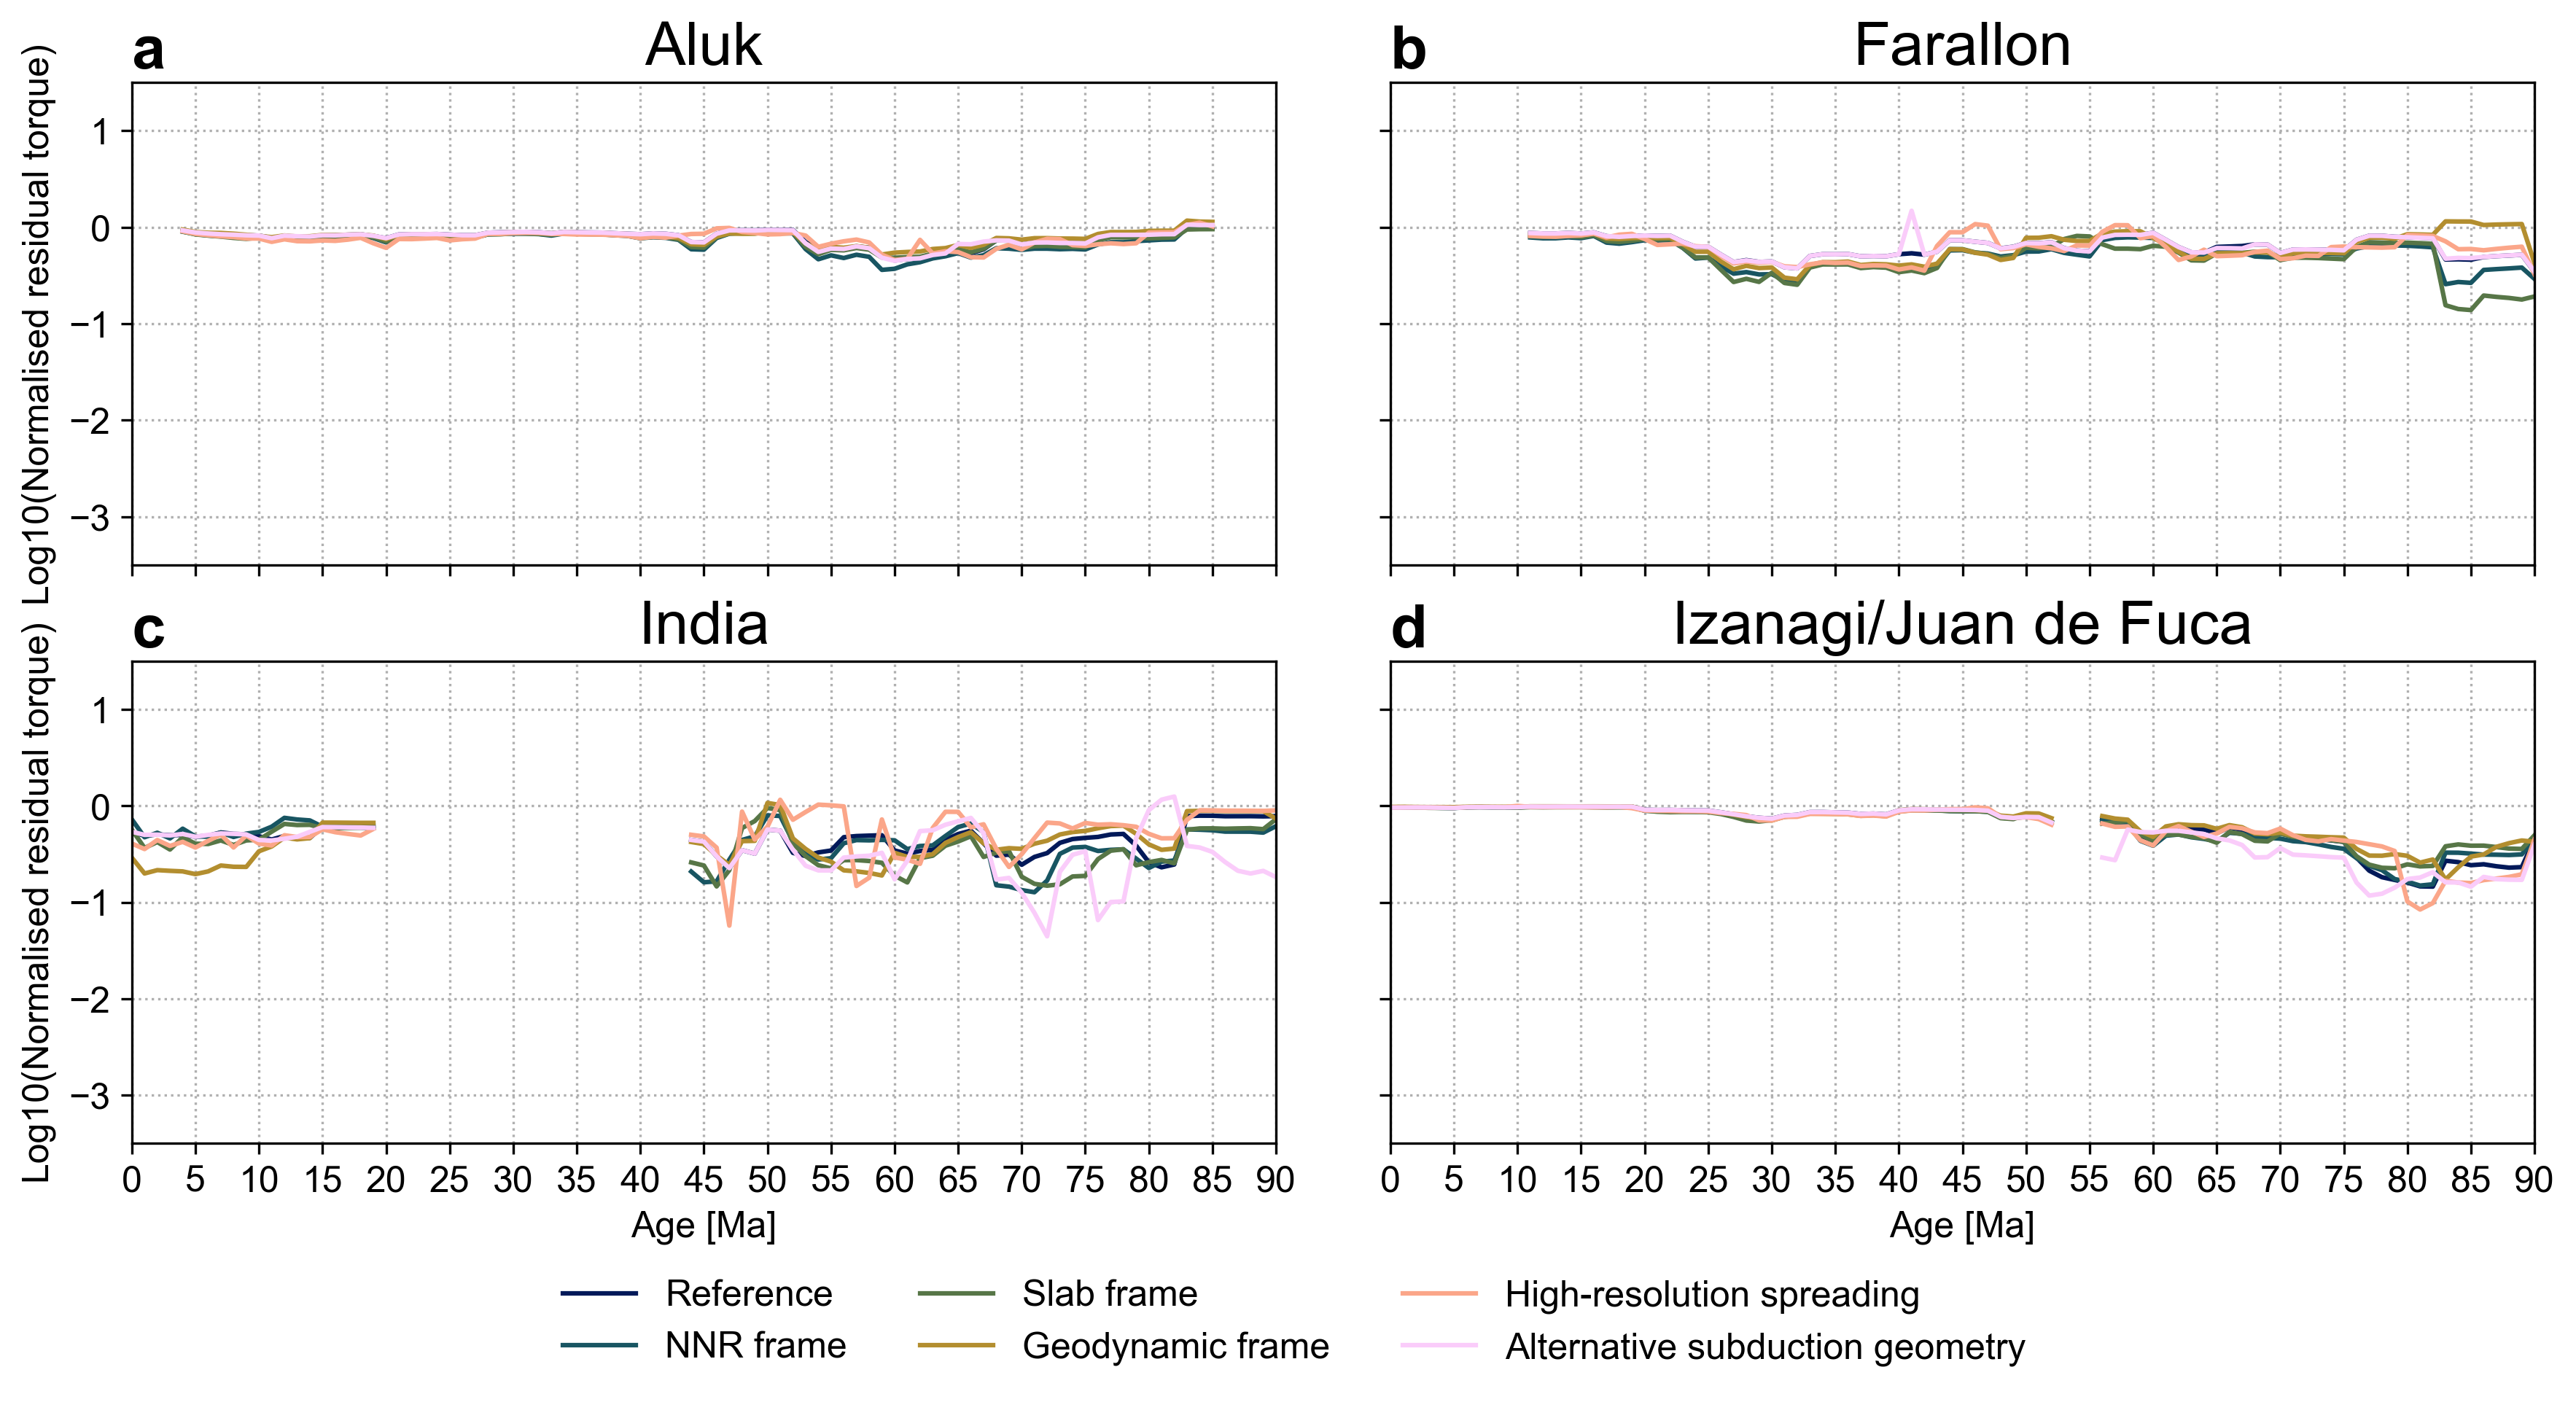

In [22]:
# Create a figure and gridspec
fig = plt.figure(figsize=(fig_width, fig_height_graphs), dpi=300)
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1], wspace=0.1, hspace=0.2)

plot_plateIDs = [904, 902, 501, 926]
plot_plate_names = ["Aluk", "Farallon", "India", "Izanagi/Juan de Fuca"]
plot_titles = ["Reference", "NNR frame", "Slab frame", "Geodynamic frame", "High-resolution spreading", "Alternative subduction geometry"]

# Plot the residual torques
m = 0
for i in range(2):
    for j in range(2):
        ax = plt.subplot(gs[i, j])
        ax.set_title(f"{plot_plate_names[m]}", fontsize=title_fontsize)
        for k, ((key, residual), (_, driving)) in enumerate(zip(residual_torque.items(), driving_torque.items())):
            if key == "Lr-Hb":
                ax.plot(residual["ref"]["Age"], np.log10(residual["ref"][plot_plateIDs[m]]/driving["ref"][plot_plateIDs[m]]), label = plot_titles[0], color = model_colours[0])
                ax.plot(residual["ref"]["Age"], np.log10(residual["nnr"][plot_plateIDs[m]]/driving["nnr"][plot_plateIDs[m]]), label = plot_titles[1], color = model_colours[1])
            else:
                ax.plot(residual["Age"], np.log10(residual[plot_plateIDs[m]]/driving[plot_plateIDs[m]]), label = plot_titles[k+1], color = model_colours[k+1])

            if plot_plateIDs[m] == 926:
                if key == "Lr-Hb":
                    ax.plot(residual["ref"]["Age"], np.log10(residual["ref"][903]/driving["ref"][903]), color = model_colours[0])
                    ax.plot(residual["ref"]["Age"], np.log10(residual["nnr"][903]/driving["nnr"][903]), color = model_colours[1])
                else:
                    ax.plot(residual["Age"], np.log10(residual[903]/driving[903]), color = model_colours[k+1])

        ax.grid(ls=":")
        
        ax.set_xlim(residual["Age"].min(), residual["Age"].max())
        ax.set_ylim(-3.5, 1.5)

        ax.set_xticks(np.arange(residual["Age"].min(), residual["Age"].max()+1, 5))

        ax.set_xticklabels([]) if i == 0 else None
        ax.set_yticklabels([]) if j == 1 else None

        ax.set_xlabel("Age [Ma]") if i == 1 else None
        ax.set_ylabel("Log10(Normalised residual torque)") if j == 0 else None

        ax.annotate(annotations[m], xy=(0, 1.03), xycoords="axes fraction", fontweight="bold", fontsize=title_fontsize)

        m += 1

# Add a legend below the entire figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3, frameon=False, bbox_to_anchor=(0.5, -0.075))

fig.savefig(os.path.join(figs_dir, "M2016_residual_torques_1.png"), bbox_inches="tight")

plt.show()

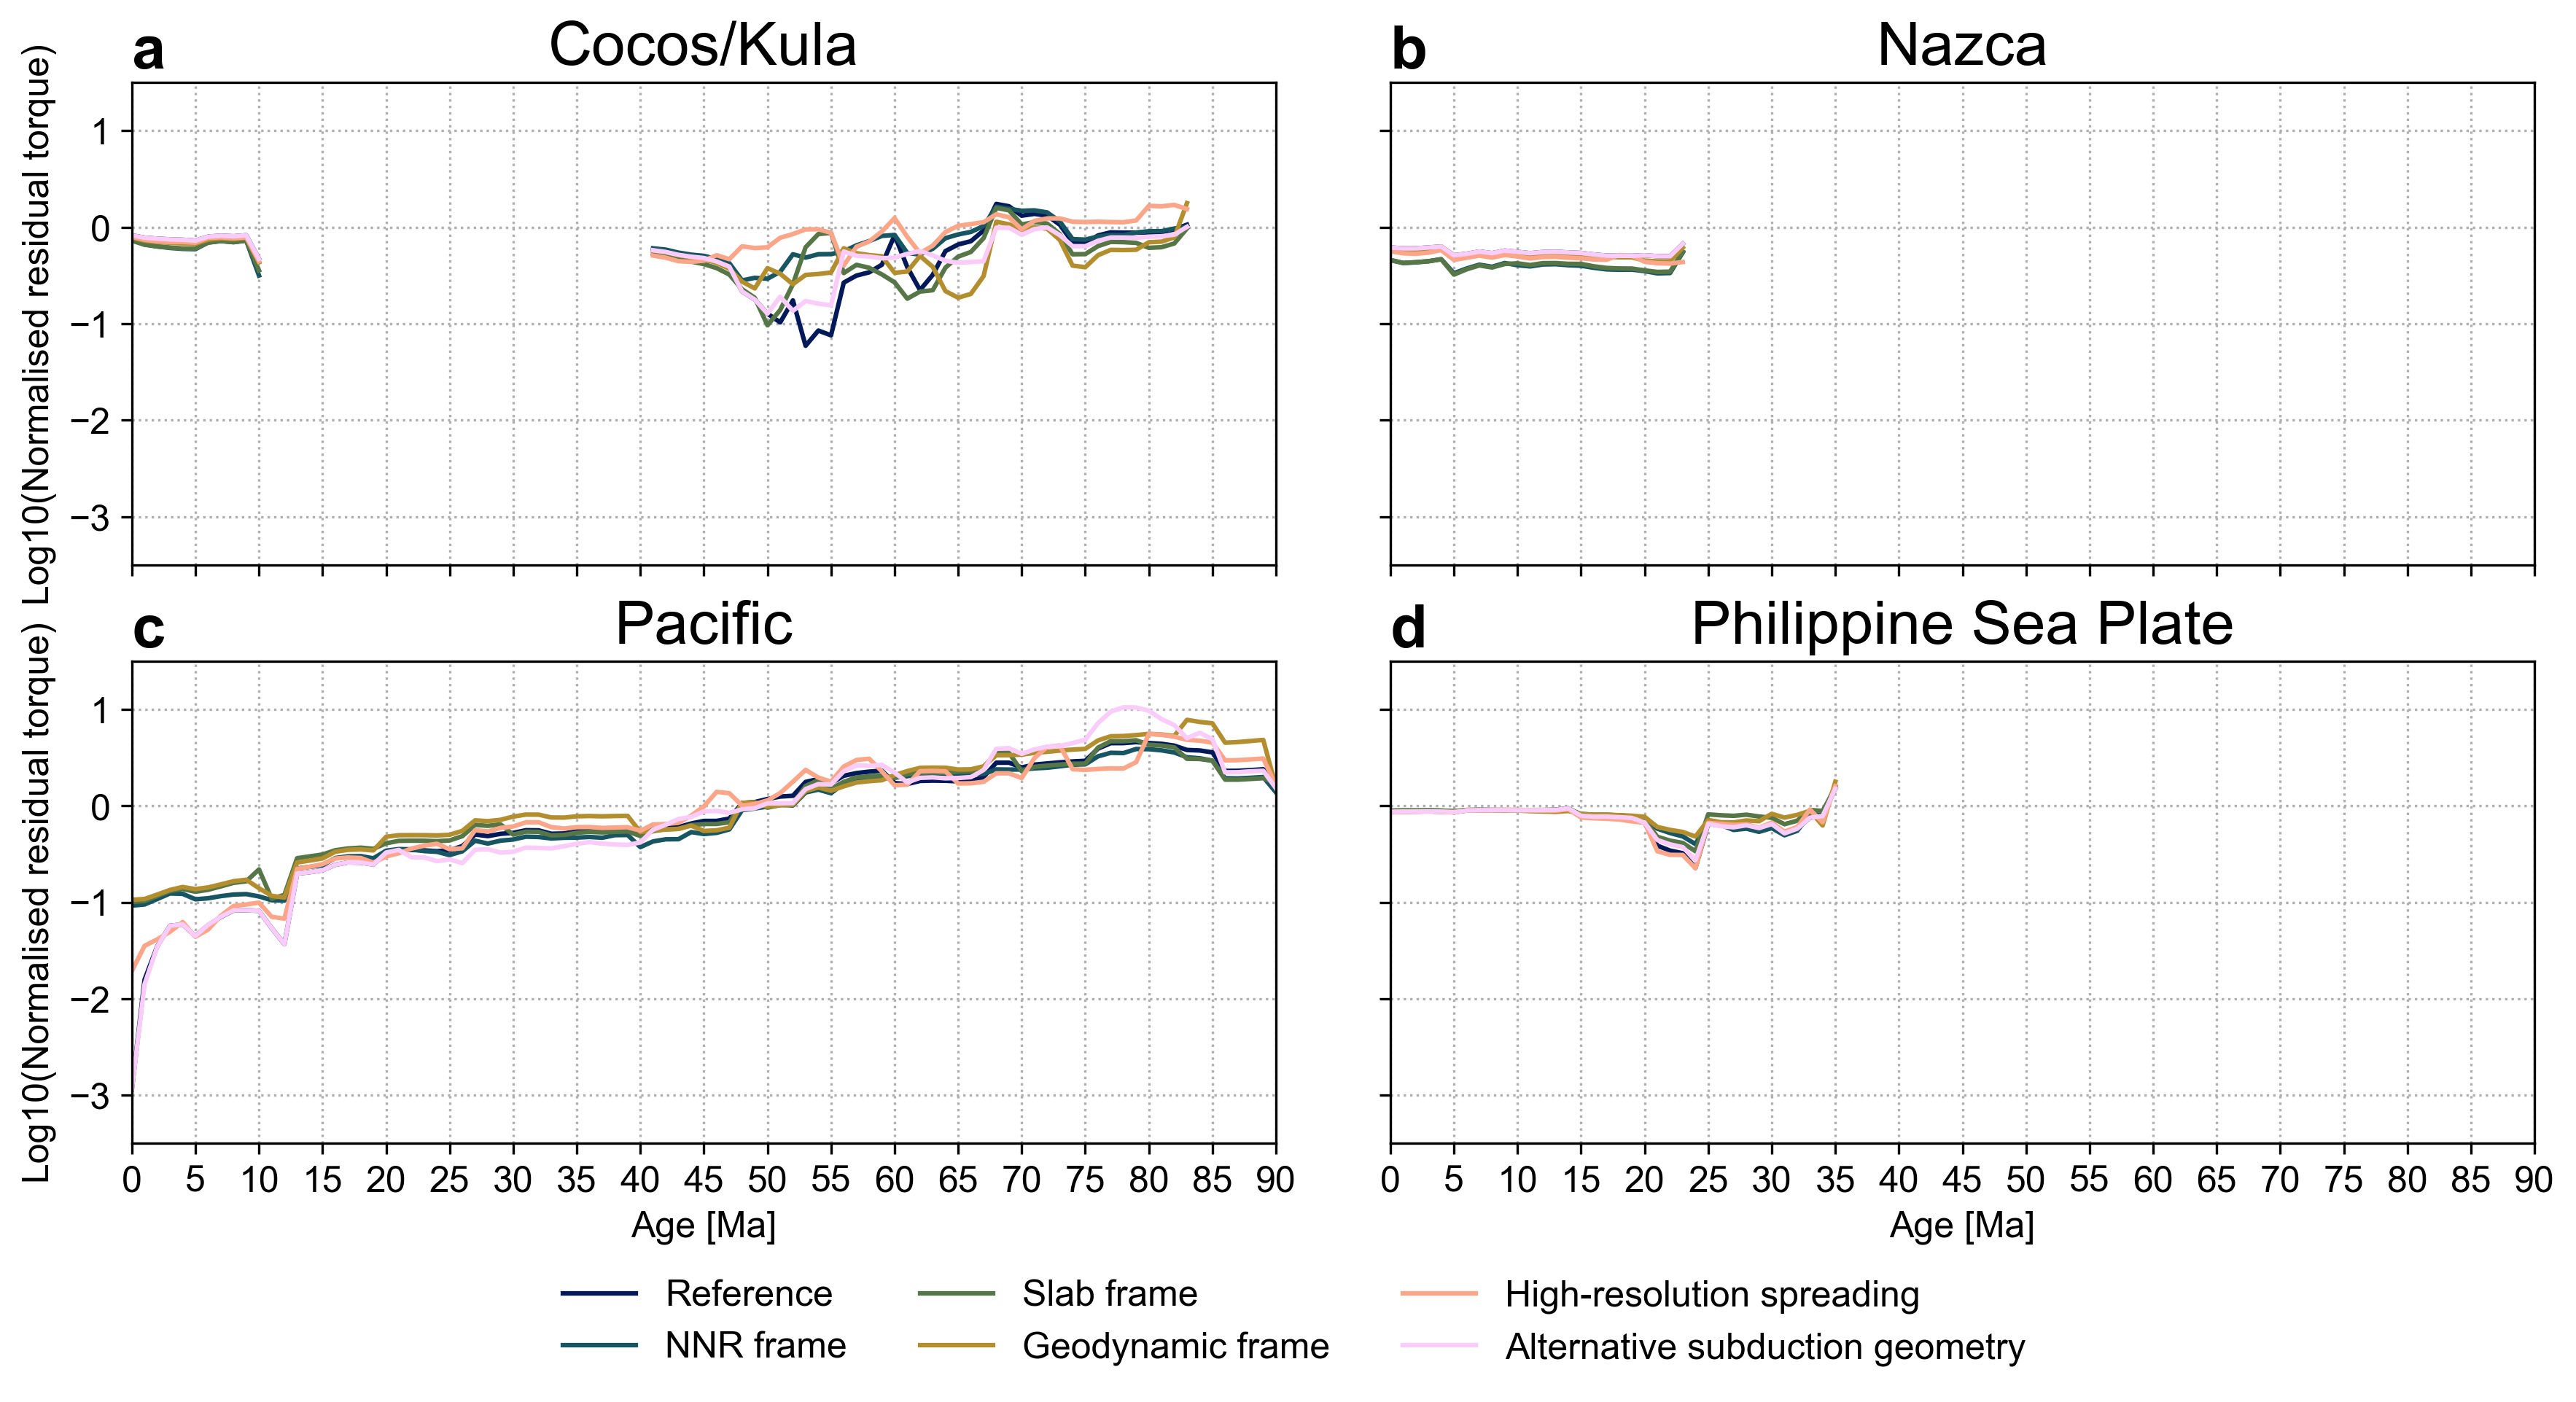

In [21]:
# Create a figure and gridspec
fig = plt.figure(figsize=(fig_width, fig_height_graphs), dpi=300)
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1], wspace=0.1, hspace=0.2)

plot_plateIDs = [909, 911, 901, 608]
plot_plate_names = ["Cocos/Kula", "Nazca", "Pacific", "Philippine Sea Plate"]
plot_titles = ["Reference", "NNR frame", "Slab frame", "Geodynamic frame", "High-resolution spreading", "Alternative subduction geometry"]

# Plot the residual torques
m = 0
for i in range(2):
    for j in range(2):
        ax = plt.subplot(gs[i, j])
        ax.set_title(f"{plot_plate_names[m]}", fontsize=title_fontsize)
        for k, ((key, residual), (_, driving)) in enumerate(zip(residual_torque.items(), driving_torque.items())):
            if key == "Lr-Hb":
                ax.plot(residual["ref"]["Age"], np.log10(residual["ref"][plot_plateIDs[m]]/driving["ref"][plot_plateIDs[m]]), label = plot_titles[0], color = model_colours[0])
                ax.plot(residual["ref"]["Age"], np.log10(residual["nnr"][plot_plateIDs[m]]/driving["nnr"][plot_plateIDs[m]]), label = plot_titles[1], color = model_colours[1])
            else:
                ax.plot(residual["Age"], np.log10(residual[plot_plateIDs[m]]/driving[plot_plateIDs[m]]), label = plot_titles[k+1], color = model_colours[k+1])

        if plot_plate_names[m] == "Cocos/Kula":
            for k, ((key, residual), (_, driving)) in enumerate(zip(residual_torque.items(), driving_torque.items())):
                if key == "Lr-Hb":
                    ax.plot(residual["ref"]["Age"], np.log10(residual["ref"][918]/driving["ref"][918]), color = model_colours[0])
                    ax.plot(residual["ref"]["Age"], np.log10(residual["nnr"][918]/driving["nnr"][918]), color = model_colours[1])
                else:
                    ax.plot(residual["Age"], np.log10(residual[918]/driving[918]), color = model_colours[k+1])

        ax.grid(ls=":")
        
        ax.set_xlim(residual["Age"].min(), residual["Age"].max())
        ax.set_ylim(-3.5, 1.5)

        ax.set_xticks(np.arange(residual["Age"].min(), residual["Age"].max()+1, 5))

        ax.set_xticklabels([]) if i == 0 else None
        ax.set_yticklabels([]) if j == 1 else None

        ax.set_xlabel("Age [Ma]") if i == 1 else None
        ax.set_ylabel("Log10(Normalised residual torque)") if j == 0 else None

        ax.annotate(annotations[m], xy=(0, 1.03), xycoords="axes fraction", fontweight="bold", fontsize=title_fontsize)

        m += 1

# Add a legend below the entire figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3, frameon=False, bbox_to_anchor=(0.5, -0.075))

fig.savefig(os.path.join(figs_dir, "M2016_residual_torques_2.png"), bbox_inches="tight")

plt.show()

In [15]:
# Initialise PlotReconstruction objects
plot_M2016 = {}
for key, model in M2016.items():
    plot_M2016[key] = PlotReconstruction(model, coastline_file=os.path.join(data_dir, "gplates_files", "M2016_coastlines.gpml"))

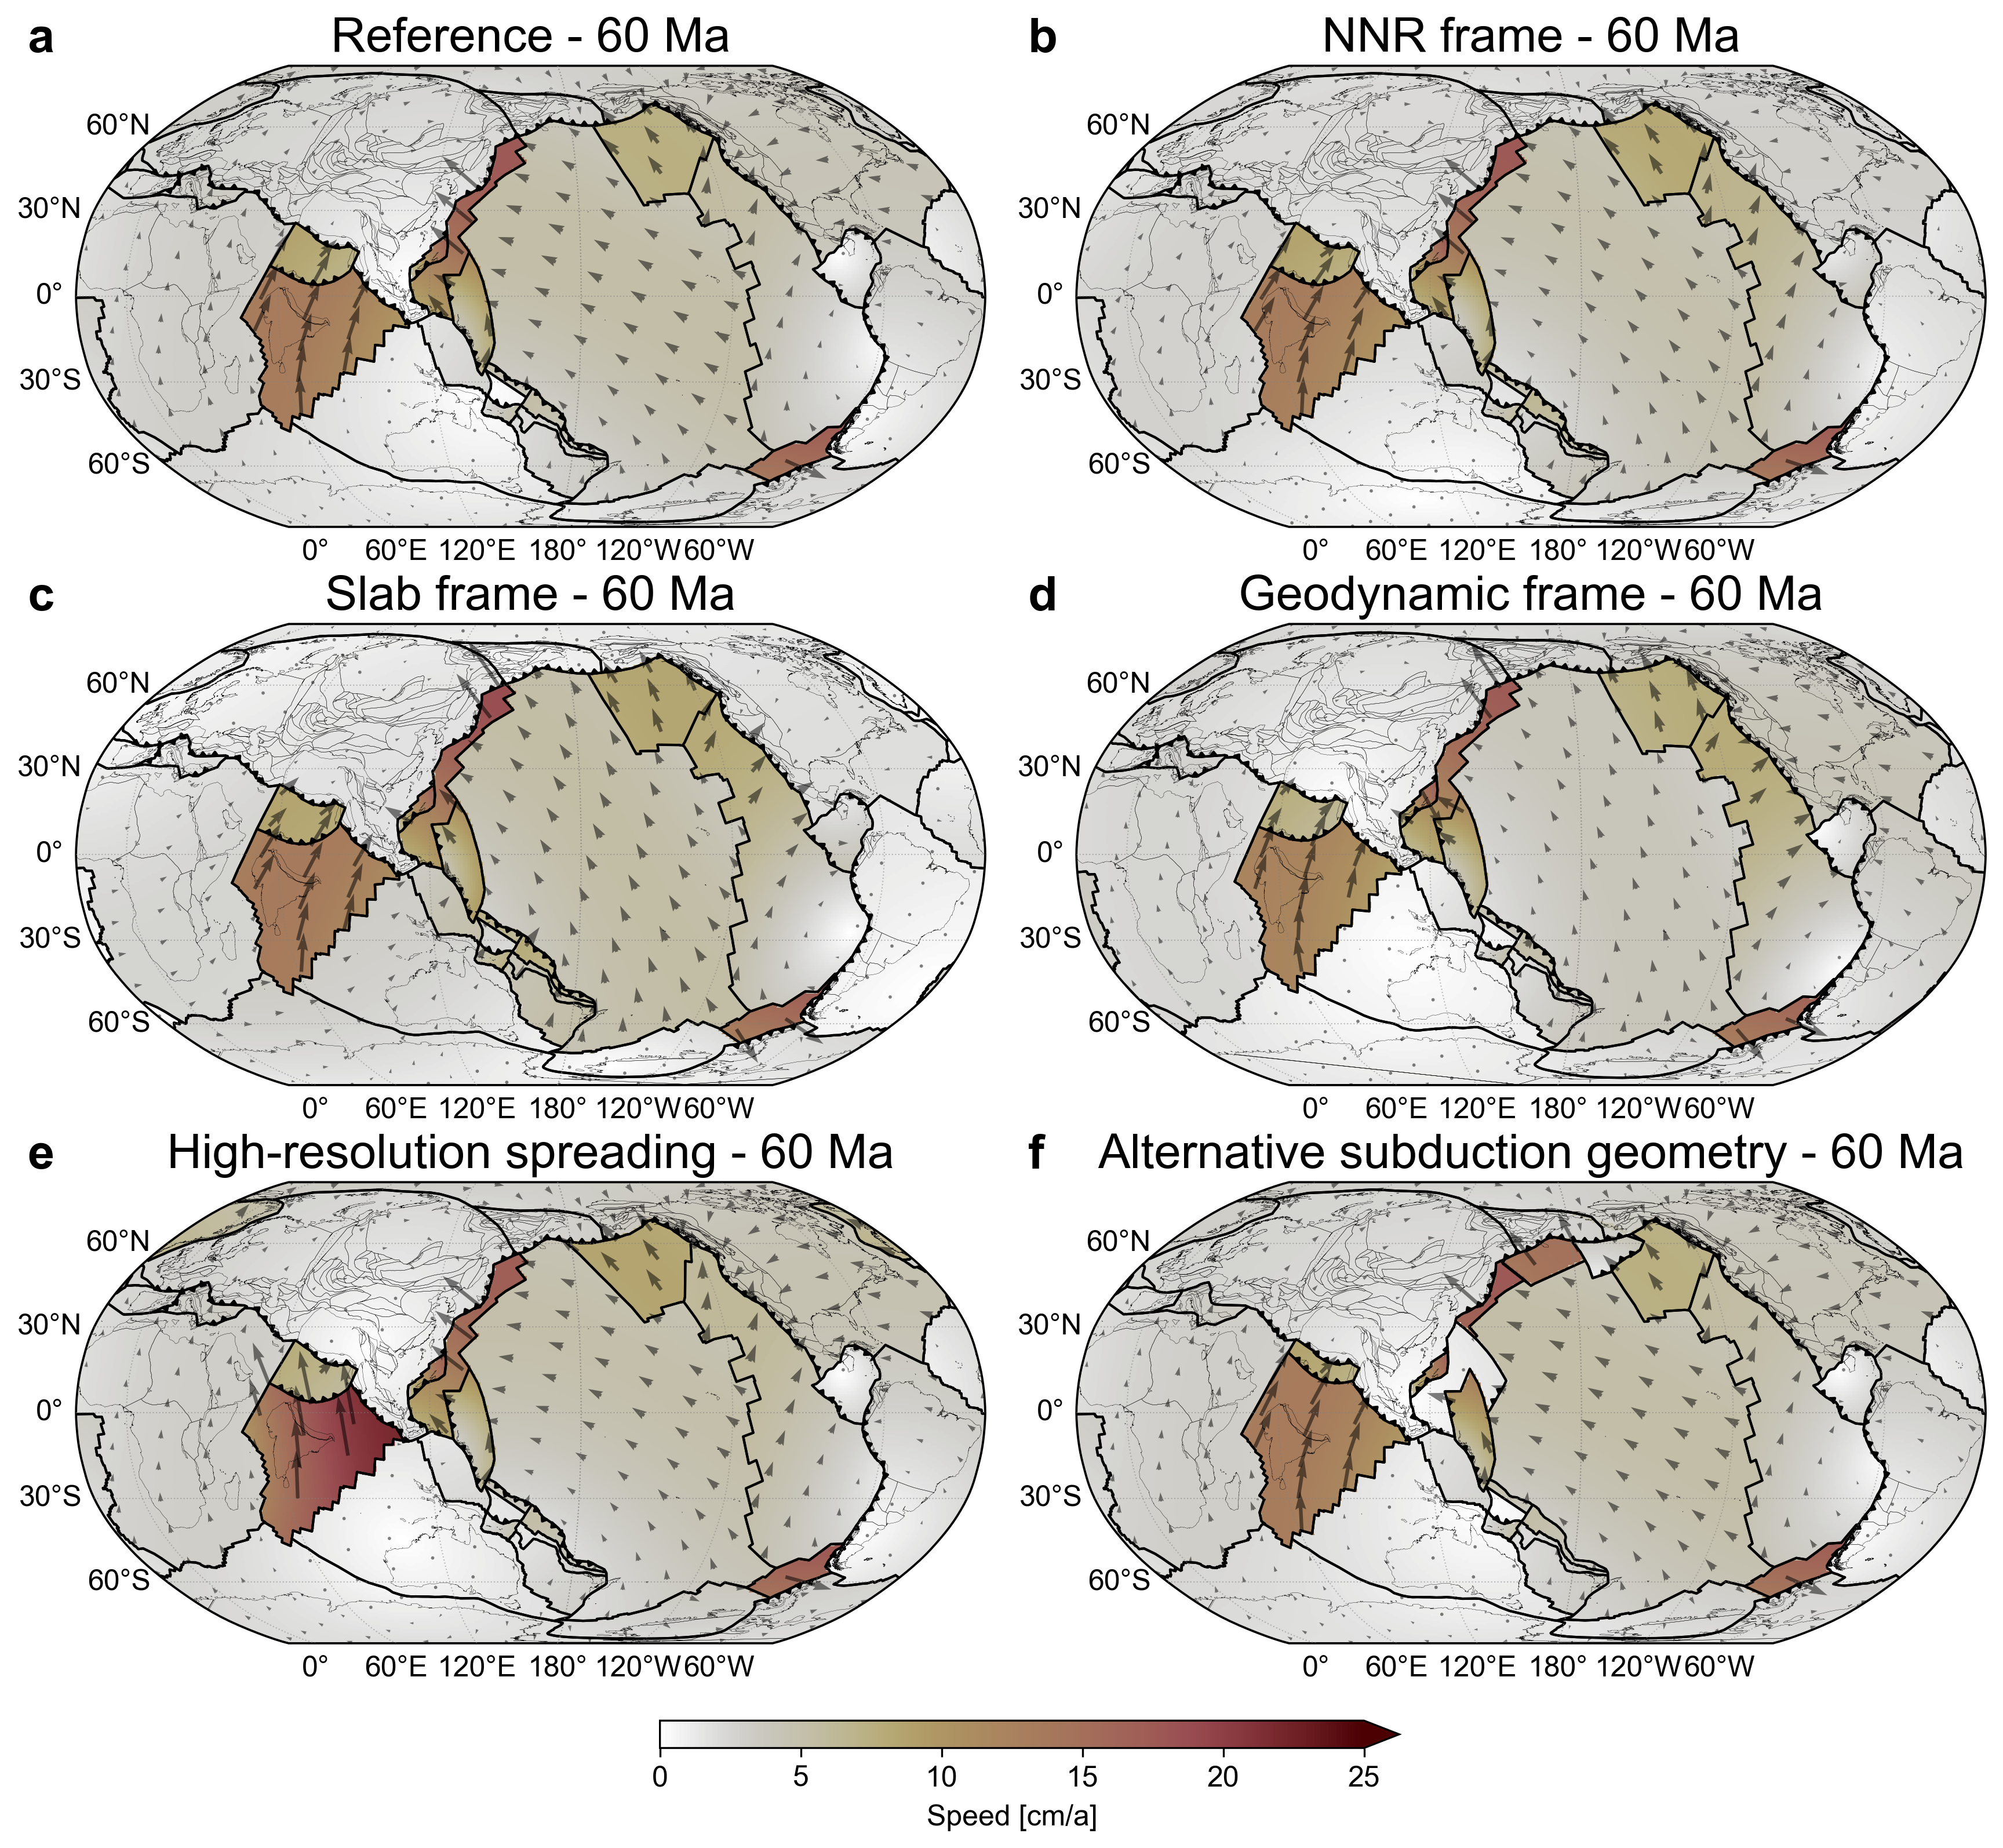

In [24]:
if PLOT_FIGS:
    plot_ages = [60]

    for plot_age in plot_ages:
        # Create a figure and gridspec
        fig = plt.figure(figsize=(fig_width, fig_height_maps*1.5), dpi=300)
        gs = gridspec.GridSpec(3, 2, wspace=0.1, hspace=0.2)

        plot_models = ["Lr-Hb", "Lr-NNR", "Lr-Sl", "Lr-Gd", "Hr-Hb", "Lr-Hb_alt"]

        plot_titles = ["Reference", "NNR frame", "Slab frame", "Geodynamic frame", "High-resolution spreading", "Alternative subduction geometry"]
        
        # Plot slab pull constant along trenches for each case
        m = 0
        for i in range(3):
            for j in range(2):
                ax = plt.subplot(gs[i, j], projection=projection)
                ax.set_title(f"{plot_titles[m]} - {plot_age} Ma", fontsize=title_fontsize)
                if plot_models[m] == "Lr-NNR":
                    vels = plot_M2016["Lr-Hb"].plot_velocity_map(ax, plot_age, case = "nnr")
                else:
                    vels = plot_M2016[plot_models[m]].plot_velocity_map(ax, plot_age, case = "ref")
    
                ax.annotate("abcdef"[m], xy=(-0.053, 1.03), xycoords="axes fraction", fontsize=title_fontsize, fontweight="bold")
                
                m += 1

        # Create a new grid for the colourbar
        cax = fig.add_axes([0.362, 0.06, 0.3, 0.02/1.5])

        # Create a colourbar below the subplots
        cbar = plt.colorbar(vels[0], cax=cax, orientation="horizontal", extend="max", extendfrac=5e-2)

        # Set colourbar label
        cbar.set_label("Speed [cm/a]", labelpad=5)

        fig.savefig(os.path.join(figs_dir, "M2016_velocity_field.png"), bbox_inches="tight")

        plt.show()